In [11]:
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from statistics import mean

In [12]:
RECORD_FILE = "record.csv"
START_TIME = datetime.strptime("2016-10-16 12:00:00", "%Y-%m-%d %H:%M:%S")

In [13]:
# Constants
HOURS = 24
MS_IN_M = 60000

In [14]:
# Read data
with open(RECORD_FILE) as f:
    data = []
    for line in f:
        data.append(line.strip().split(",", 3))

ECG_records = pd.DataFrame(
    data, columns=["wave_type", "wave_onset", "wave_offset", "tags"]
)

In [15]:
# Count p-wave and qrs-complex ith "premature" tags
p_wave_premature = len(
    ECG_records[
        (ECG_records.wave_type == "P") & (ECG_records.tags.str.contains("premature"))
    ]
)
qrs_complex_premature = len(
    ECG_records[
        (ECG_records.wave_type == "QRS") & (ECG_records.tags.str.contains("premature"))
    ]
)

In [20]:
print("'Premature' tags amount:")
print(f"P-wave: {p_wave_premature}")
print(f"QRS-complex: {qrs_complex_premature}")

'Premature' tags amount:
P-wave: 315
QRS-complex: 149


In [17]:
# count min, max, mean heart rate
onset_time = [int(x) for x in ECG_records[ECG_records.wave_type == "QRS"]["wave_onset"]]

max_heart_rate = 0
min_heart_rate = 1000
max_heart_rate_time = 0
min_heart_rate_time = 0

n_minute = 1
n_qrs_per_min = 0
heart_rates_per_minute = []
for ms_time in onset_time:
    if ms_time >= n_minute * MS_IN_M:
        n_minute += 1
        heart_rates_per_minute.append(n_qrs_per_min)
        datetime = (START_TIME + timedelta(milliseconds=ms_time)).strftime(
            "%Y-%m-%d %H:%M:%S"
        )

        if n_qrs_per_min > max_heart_rate:
            max_heart_rate = n_qrs_per_min
            max_heart_rate_time = datetime
        elif n_qrs_per_min < min_heart_rate:
            min_heart_rate = n_qrs_per_min
            min_heart_rate_time = datetime

        n_qrs_per_min = 0
    n_qrs_per_min += 1

mean_heart_rate_per_hour = []
min_heart_rate_per_hour = []
max_heart_rate_per_hour = []

for h in range(HOURS):
    heart_rates_per_hour = heart_rates_per_minute[h * 60 : (h + 1) * 60]
    mean_heart_rate_per_hour.append(mean(heart_rates_per_hour))
    min_heart_rate_per_hour.append(min(heart_rates_per_hour))
    max_heart_rate_per_hour.append(max(heart_rates_per_hour))

mean_heart_rate = round(mean(mean_heart_rate_per_hour))
max_heart_rate = max(max_heart_rate_per_hour)
min_heart_rate = min(min_heart_rate_per_hour)


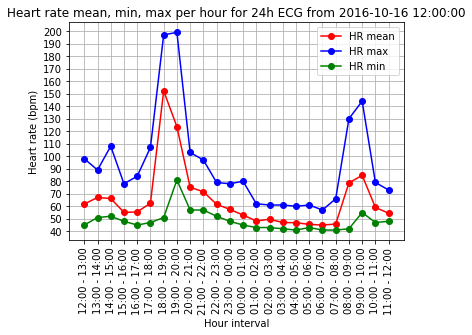

In [18]:
# plot
hours = [(START_TIME + timedelta(hours=h)).strftime("%H:%M") for h in range(HOURS + 1)]
hour_intervals = [f"{hours[i]} - {hours[i+1]}" for i in range(len(hours[:-1]))]

f = plt.figure()
plt.plot(mean_heart_rate_per_hour, color="r", marker="o")
plt.plot(max_heart_rate_per_hour, color="b", marker="o")
plt.plot(min_heart_rate_per_hour, color="g", marker="o")

plt.title(f"Heart rate mean, min, max per hour for 24h ECG from {START_TIME}")
plt.legend(["HR mean", "HR max", "HR min"])
plt.xticks(range(24), hour_intervals, rotation="vertical")
plt.yticks(range(40, 210, 10))
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hour interval")
plt.grid()